<a href="https://colab.research.google.com/github/minassy/ISID_2021/blob/main/210927_Sub2%E6%94%B9_%E5%8D%98%E3%83%A6%E3%83%8B%E3%83%83%E3%83%88%E5%AD%A6%E7%BF%92.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import zipfile
import glob
import pandas as pd
import numpy as np
import math
import statistics
import pathlib
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#作業基本ディレクトリ
DIR = 'drive/MyDrive/00_Competition/ISID/2021'
#学習データディレクトリ
DIR_DATA_TRAIN = os.path.join(DIR, 'data', 'Train_Unit_20210903')
#テストデータディレクトリ
DIR_DATA_TEST = os.path.join(DIR, 'data', 'Test_Unit_20210903')

In [3]:
#一連のデータ処理
def get_some_values(file_path):
  #ファイルパスから、ユニット名を取得。
  dirname = os.path.dirname(file_path)
  dirname_split = dirname.split('/')#区切り文字'/'で分割
  unit = dirname_split[-2]
  charge_mode = dirname_split[-1]
  #ファイルパスから、サイクル数を取得。
  basename = os.path.basename(file_path)
  basename_split = basename.split('_')[4]#区切り文字'_'で分割
  cycle_num = basename_split.split('.')[0]
  return unit, charge_mode, cycle_num

#%time
#DATA_DIR = DIR_DATA_TRAIN
#DATA_DIR = DIR_DATA_TEST

#C = 'Charge'
#C = 'Discharge'

def data_reading(DATA_DIR, C):

  #カラム名変更前後の辞書
  col_list = {'Time (s)' : 'Time',
              'Voltage Measured (V)' : 'VM',
              'Voltage Charge (V)' : 'VC',
              'Current Measured (Amps)' : 'CM', 
              'Current Charge (Amps)' : 'CC',
              'Temperature (degree C)': 'Temp', 
              'unit' : 'unit_name', 
              'charge_mode' : 'mode', 
              'Cycle_num' : 'Cycle',
              'Voltage Load (V)' : 'VL',
              'Current Load (Amps)' : 'CL'
  }

  df_list = []
  for folder in tqdm(os.listdir(DATA_DIR)[:3]):
    files = glob.glob(os.path.join(DATA_DIR, folder, C, '*.csv'))
    df_list_0 = []
    for file in files:
      tmp_df = pd.read_csv(file, encoding='utf-8')
      tmp_df = tmp_df.rename(columns=col_list)
      #ユニット名、充・放電モード、サイクル数の取得
      unit, charge_mode, cycle_num = get_some_values(file)
      #特徴量のデータフレームの作成
      if C == 'Charge':
        df_exp = pd.DataFrame([{'unit':unit,
                          'charge_mode' : charge_mode,
                          'Cycle_num' : int(cycle_num),
                          'feature_c_vm' : featured_c_vm(tmp_df),
                          'feature_c_cm' : featured_c_cm(tmp_df),
                          'feature_c_vc' : featured_c_vc(tmp_df)}])
      else:
        df_exp = pd.DataFrame([{'unit':unit,
                          'charge_mode' : charge_mode,
                          'Cycle_num' : int(cycle_num),
                          'feature_d_vm' : featured_d_vm(tmp_df),
                          'feature_d_vl' : featured_d_vl(tmp_df)}])
      df_list_0.append(df_exp)
    df_0 = pd.concat(df_list_0)
    df_list.append(df_0)
  df = pd.concat(df_list)

  #ユニットとサイクルでソート。
  df = df.sort_values(['unit', 'Cycle_num'])
  #インデックスの振り直し
  df = df.reset_index(drop=True)

  return df

def featured_c_vm(df):
  #LAG=5が0.001未満が続くところを、飽和領域とみなす。
  p_c_vm = df.loc[:, 'VM'][df.loc[:, 'VM'].diff(5) < 0.001]
  #飽和領域のなかで、最初の点を点P_C_VMとする。
  p_c_vm = p_c_vm.reset_index(inplace=False)
  p_c_vm = p_c_vm['index'].iloc[0]
  #充電VMの特徴量は、点P_C_VMにおける時間
  feature_c_vm = df['Time'].loc[p_c_vm]
  return feature_c_vm

def featured_c_cm(df):
  #飽和領域からの立ち下がり点(LAG=5の勾配が最小となる点)を点P_C_CMとする。
  p_c_cm = np.gradient(df.loc[:, 'CM'].diff(5)[10:]).argmin()
  #充電CMの特徴量は、点P_C_CMにおける時間
  feature_c_cm = df['Time'].loc[p_c_cm]
  return feature_c_cm

def featured_c_vc(df):
  #VCが最大値を示す点を、点P_C_VCとする。
  p_c_vc = df.VC.argmax()
  #充電VCの特徴量は、点P_C_VCにおける時間
  feature_c_vc = df['Time'].loc[p_c_vc]
  return feature_c_vc

def featured_d_vm(df):
  #VMが最小値を示す点を、点P_D_VMとする。
  p_d_vm = df.VM.argmin()
  #放電VMの特徴量は、点P_D_VMにおける時間
  feature_d_vm = df['Time'].loc[p_d_vm]
  return feature_d_vm

def featured_d_vl(df):
  #VLの最大値点以降の領域において、最小値を示す点を、点P_D_VLとする。
  VL_max = df.VL.argmax()
  p_d_vl = df.VL[VL_max: ].argmin()
  #放電VLの特徴量は、点P_D_VLにおける時間
  feature_d_vl = df['Time'].loc[p_d_vl]
  return feature_d_vl

In [4]:
%time
#データの読み込み(学習)
#充電

DATA_DIR = DIR_DATA_TRAIN
#DATA_DIR = DIR_DATA_TEST

C = 'Charge'
#C = 'Discharge'

df_train_charge = data_reading(DATA_DIR, C)

#データの読み込み(学習)
#放電

DATA_DIR = DIR_DATA_TRAIN
#DATA_DIR = DIR_DATA_TEST

#C = 'Charge'
C = 'Discharge'

df_train_discharge = data_reading(DATA_DIR, C)

#充電と放電の特徴量のデータセット作成
df_train_feature = pd.merge(df_train_charge, df_train_discharge,
                            how = 'inner',
                            on = ['unit', 'Cycle_num'])

#データの読み込み(学習)
#充電

#DATA_DIR = DIR_DATA_TRAIN
DATA_DIR = DIR_DATA_TEST

C = 'Charge'
#C = 'Discharge'

df_test_charge = data_reading(DATA_DIR, C)

#データの読み込み(学習)
#放電

#DATA_DIR = DIR_DATA_TRAIN
DATA_DIR = DIR_DATA_TEST

#C = 'Charge'
C = 'Discharge'

df_test_discharge = data_reading(DATA_DIR, C)

#充電と放電の特徴量のデータセット作成
df_test_feature = pd.merge(df_test_charge, df_test_discharge,
                            how = 'inner',
                            on = ['unit', 'Cycle_num'])


CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.48 µs


100%|██████████| 3/3 [00:28<00:00,  9.35s/it]


In [23]:
df_train = df_train_feature.copy()

In [24]:
df_test = df_test_feature.copy()

データセットの改善

RLU列を設定

In [25]:
num_train_unit_1 = 124
num_train_unit_2 = 40
num_train_unit_3 = 97

num_test_unit_1 = 70
num_test_unit_2 = 12
num_test_unit_3 = 55

In [26]:
df_train.head()
#df_train.shape

,unit,charge_mode_x,Cycle_num,feature_c_vm,feature_c_cm,feature_c_vc,charge_mode_y,feature_d_vm,feature_d_vl
0,Train_Unit_1,Charge,1,3422.5,3207.4,3241.8,Discharge,3346.9,3327.2
1,Train_Unit_1,Charge,2,3431.6,3181.8,3262.3,Discharge,3328.8,3309.2
2,Train_Unit_1,Charge,3,3409.1,9692.7,3229.2,Discharge,3309.4,3289.8
3,Train_Unit_1,Charge,4,3407.7,3160.2,3228.2,Discharge,3309.7,3289.9
4,Train_Unit_1,Charge,5,3409.6,3172.4,3217.9,Discharge,3307.7,3287.9


In [27]:
#寿命列を付与する関数
def add_LT(x):
  if x == 'Train_Unit_1':
    return num_train_unit_1

  elif x == 'Train_Unit_2':
    return num_train_unit_2
  
  elif x == 'Train_Unit_3':
    return num_train_unit_3

In [28]:
df_train['LifeTime'] = df_train['unit'].apply(add_LT)

In [29]:
df_train.head()

,unit,charge_mode_x,Cycle_num,feature_c_vm,feature_c_cm,feature_c_vc,charge_mode_y,feature_d_vm,feature_d_vl,LifeTime
0,Train_Unit_1,Charge,1,3422.5,3207.4,3241.8,Discharge,3346.9,3327.2,124
1,Train_Unit_1,Charge,2,3431.6,3181.8,3262.3,Discharge,3328.8,3309.2,124
2,Train_Unit_1,Charge,3,3409.1,9692.7,3229.2,Discharge,3309.4,3289.8,124
3,Train_Unit_1,Charge,4,3407.7,3160.2,3228.2,Discharge,3309.7,3289.9,124
4,Train_Unit_1,Charge,5,3409.6,3172.4,3217.9,Discharge,3307.7,3287.9,124


In [30]:
#RULを付与
df_train['RUL'] = df_train['LifeTime'] - df_train['Cycle_num']

In [31]:
df_train.head()

,unit,charge_mode_x,Cycle_num,feature_c_vm,feature_c_cm,feature_c_vc,charge_mode_y,feature_d_vm,feature_d_vl,LifeTime,RUL
0,Train_Unit_1,Charge,1,3422.5,3207.4,3241.8,Discharge,3346.9,3327.2,124,123
1,Train_Unit_1,Charge,2,3431.6,3181.8,3262.3,Discharge,3328.8,3309.2,124,122
2,Train_Unit_1,Charge,3,3409.1,9692.7,3229.2,Discharge,3309.4,3289.8,124,121
3,Train_Unit_1,Charge,4,3407.7,3160.2,3228.2,Discharge,3309.7,3289.9,124,120
4,Train_Unit_1,Charge,5,3409.6,3172.4,3217.9,Discharge,3307.7,3287.9,124,119


モデリング

In [32]:
#学習データとテストデータ
train_unit_1 = df_train[df_train['unit'] == 'Train_Unit_1' ].reset_index(drop=True)
train_unit_2 = df_train[df_train['unit'] == 'Train_Unit_2' ].reset_index(drop=True)
train_unit_3 = df_train[df_train['unit'] == 'Train_Unit_3' ].reset_index(drop=True)
test_unit_1 = df_test[df_test['unit'] == 'Test_Unit_1' ].reset_index(drop=True)
test_unit_2 = df_test[df_test['unit'] == 'Test_Unit_2' ].reset_index(drop=True)
test_unit_3 = df_test[df_test['unit'] == 'Test_Unit_3' ].reset_index(drop=True)

In [15]:
df_train.columns

Index(['unit', 'charge_mode_x', 'Cycle_num', 'feature_c_vm', 'feature_c_cm',
       'feature_c_vc', 'charge_mode_y', 'feature_d_vm', 'feature_d_vl',
       'LifeTime', 'RUL'],
      dtype='object')

In [34]:
col_train = df_train.columns[3:].drop(['charge_mode_y','LifeTime'])
col_train

Index(['feature_c_vm', 'feature_c_cm', 'feature_c_vc', 'feature_d_vm',
       'feature_d_vl', 'RUL'],
      dtype='object')

In [35]:
col_test = df_test.columns[3:].drop(['charge_mode_y'])
col_test

Index(['feature_c_vm', 'feature_c_cm', 'feature_c_vc', 'feature_d_vm',
       'feature_d_vl'],
      dtype='object')

ユニット1用

In [38]:
train_X_1 = train_unit_1[col_train[:-1]]
train_y_1 = train_unit_1[col_train[-1]]
train_X_2 = train_unit_2[col_train[:-1]]
train_y_2 = train_unit_2[col_train[-1]]
train_X_3 = train_unit_3[col_train[:-1]]
train_y_3 = train_unit_3[col_train[-1]]

In [37]:
print(train_X_1)
print(train_y_1)

     feature_c_vm  feature_c_cm  feature_c_vc  feature_d_vm  feature_d_vl
0         3422.50        3207.4        3241.8        3346.9        3327.2
1         3431.60        3181.8        3262.3        3328.8        3309.2
2         3409.10        9692.7        3229.2        3309.4        3289.8
3         3407.70        3160.2        3228.2        3309.7        3289.9
4         3409.60        3172.4        3217.9        3307.7        3287.9
..            ...           ...           ...           ...           ...
119       1932.20        2706.9        1902.4        2577.9        2568.5
120        543.23        2894.9        1960.2        2587.0        2577.5
121        939.70        3271.7        1966.2        2549.7        2540.1
122       1970.20        2230.0        1932.3        2531.3        2521.7
123        464.92       10035.0        1886.0        2520.9        2511.4

[124 rows x 5 columns]
0      123
1      122
2      121
3      120
4      119
      ... 
119      4
120      3


In [39]:
test_X_1 = test_unit_1[col_test]
test_X_2 = test_unit_2[col_test]
test_X_3 = test_unit_3[col_test]

In [40]:
from xgboost import XGBRegressor

In [44]:
#モデルの作成
model_1 = XGBRegressor(n_estimators=20, random_state=71)
model_1.fit(train_X_1,train_y_1)

model_2 = XGBRegressor(n_estimators=20, random_state=71)
model_2.fit(train_X_2,train_y_2)

model_3 = XGBRegressor(n_estimators=20, random_state=71)
model_3.fit(train_X_3,train_y_3)

[11:27:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:27:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:27:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=20,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=71,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [45]:
#テストデータの予測値を出力
pred_1 = model_1.predict(test_X_1)
pred_2 = model_2.predict(test_X_2)
pred_3 = model_3.predict(test_X_3)

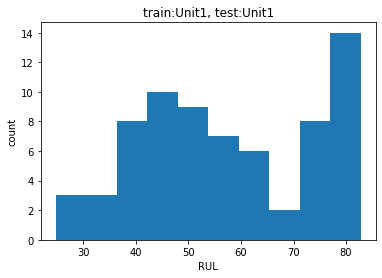

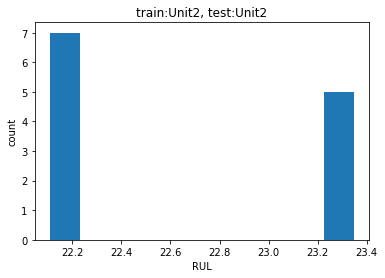

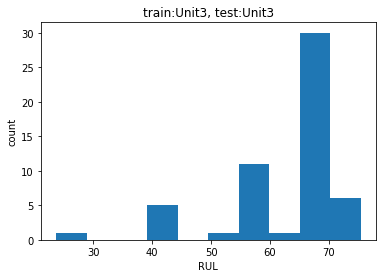

In [50]:
fig, ax1 = plt.subplots()

ax1.hist(pred_1, bins=10)
ax1.set_title('train:Unit1, test:Unit1')
ax1.set_xlabel('RUL')
ax1.set_ylabel('count')

fig, ax2 = plt.subplots()
ax2.hist(pred_2, bins=10)
ax2.set_title('train:Unit2, test:Unit2')
ax2.set_xlabel('RUL')
ax2.set_ylabel('count')

fig, ax3 = plt.subplots()
ax3.hist(pred_3, bins=10)
ax3.set_title('train:Unit3, test:Unit3')
ax3.set_xlabel('RUL')
ax3.set_ylabel('count')

plt.show()

In [51]:
#ヒストグラムの最頻値をRLUと定義
lifetime_test_1 = round(statistics.mode(pred_1))
lifetime_test_2 = round(statistics.mode(pred_2))
lifetime_test_3 = round(statistics.mode(pred_3))

print(lifetime_test_1,lifetime_test_2,lifetime_test_3)

80 22 70


# 提出

In [52]:
#残寿命の算出
RUL_unit_1 = lifetime_test_1
RUL_unit_2 = lifetime_test_2
RUL_unit_3 = lifetime_test_3

In [53]:
print(type(RUL_unit_1))
print(type(RUL_unit_2))
print(type(RUL_unit_3))

<class 'int'>
<class 'int'>
<class 'int'>


In [54]:
#提出ファイルの読み込み
file_submit = pd.read_csv(os.path.join(DIR, 'data', 'ISID_08_09_2021.csv'))

In [55]:
file_submit.columns

Index(['Unit 1 RUL', 'Unit 2 RUL', 'Unit 3 RUL'], dtype='object')

In [56]:
pd.DataFrame({
    file_submit.columns[0]: [RUL_unit_1],
    file_submit.columns[1]: [RUL_unit_2],
    file_submit.columns[2]: [RUL_unit_3],}).to_csv(os.path.join(DIR, "C0002_27_09_2021_2.csv"), index=False)